# **Neural Networks**

This notebook implements two fully custom neural networks using NumPy only:

1. Regression Neural Network

Predicts a continuous Spotify feature (we use valence)

2. Classification Neural Network

Predicts a binary class — here we classify songs as High Energy (≥0.65) vs Low Energy (<0.65)

The goal is to demonstrate:
1. Manual forward propagation
2. Manual backpropagation
3. SGD updates
4. Nonlinear activation functions
5. Loss curves
6. Prediction interpretation

This notebook mirrors the methodology used in your prior machine learning notebooks while extending into deep learning fundamentals.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("topsongs.csv")
df.head()


,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


## **Feature Selection & Preprocessing**

For consistency with your other notebooks, we select only numeric audio features:
-danceability
-energy
-loudness
-speechiness
-acousticness
-instrumentalness
-liveness
-valence
-tempo

We normalize all input features to zero mean and unit variance, which dramatically improves neural network training stability.

For the two tasks:

Regression
-Predict valence (continuous measure of musical positivity)

Classification
-High Energy = energy >= 0.65
-Low Energy = energy < 0.65

This produces a balanced-ish binary problem suitable for a small neural net.

In [6]:
# Select numeric audio features
features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

df_nn = df[features].dropna()

X = df_nn.drop("valence", axis=1).values
y_reg = df_nn["valence"].values.reshape(-1, 1)

# Classification target:
y_clf = (df_nn["energy"].values >= 0.65).astype(int).reshape(-1,1)

X_mean = X.mean(axis=0)
X_std  = X.std(axis=0)

X_norm = (X - X_mean) / X_std


## **Train/Validation/Test Split**

We use:
1. 60% training
2. 20% validation
3. 20% testing

This mirrors your methodology across all supervised models.

In [11]:
def train_val_test_split(X, y, train=0.6, val=0.2, test=0.2):
    n = len(X)
    idx = np.random.permutation(n)
    
    t1 = int(train*n)
    t2 = int((train+val)*n)

    return (
        X[idx[:t1]], y[idx[:t1]],
        X[idx[t1:t2]], y[idx[t1:t2]],
        X[idx[t2:]], y[idx[t2:]]
    )

X_tr, y_reg_tr, X_val, y_reg_val, X_te, y_reg_te = train_val_test_split(X_norm, y_reg)
_, y_clf_tr, _, y_clf_val, _, y_clf_te = train_val_test_split(X_norm, y_clf)


## **Regression Neural Network Overview**

We build the following architecture:

**Regression NN Architecture**

Input → Hidden(64) → Hidden(64) → Output(1)
Hidden activation: ReLU
Output activation: Linear
Loss: Mean Squared Error
Optimization: SGD

This structure is nearly identical to your insurance-dataset neural network.

In [16]:
class RegressionNN:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(n, 1) for n in sizes[1:]]
        self.weights = [np.random.randn(n, m) / np.sqrt(m)
                        for m, n in zip(sizes[:-1], sizes[1:])]

    def relu(self, z): return np.maximum(0, z)
    def d_relu(self, z): return (z > 0).astype(float)

    def feedforward(self, a):
        for i in range(self.num_layers - 1):
            w, b = self.weights[i], self.biases[i]
            z = w @ a + b
            if i < self.num_layers - 2:
                a = self.relu(z)
            else:
                a = z  # linear output layer
        return a

    def backprop(self, x, y):
        nabla_b = [np.zeros_like(b) for b in self.biases]
        nabla_w = [np.zeros_like(w) for w in self.weights]

        activation = x.reshape(-1,1)
        activations = [activation]
        zs = []

        # Forward pass
        for i in range(self.num_layers - 1):
            w, b = self.weights[i], self.biases[i]
            z = w @ activation + b
            zs.append(z)
            if i < self.num_layers - 2:
                activation = self.relu(z)
            else:
                activation = z
            activations.append(activation)

        # Output delta (MSE derivative)
        delta = (activations[-1] - y)
        nabla_b[-1] = delta
        nabla_w[-1] = delta @ activations[-2].T

        # Backpropagate
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.d_relu(z)
            delta = (self.weights[-l+1].T @ delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = delta @ activations[-l-1].T

        return nabla_b, nabla_w

    def SGD(self, train_data, val_data, epochs, lr):
        self.train_loss = []
        self.val_loss = []

        for ep in range(epochs):
            np.random.shuffle(train_data)
            for x, y in train_data:
                nb, nw = self.backprop(x, y)
                self.weights = [w - lr * dw for w, dw in zip(self.weights, nw)]
                self.biases = [b - lr * db for b, db in zip(self.biases, nb)]

            train_mse = np.mean([(self.feedforward(x.reshape(-1,1)) - y.reshape(-1,1))**2 for x, y in train_data])
            val_mse   = np.mean([(self.feedforward(x.reshape(-1,1)) - y.reshape(-1,1))**2 for x, y in val_data])
            
            self.train_loss.append(train_mse)
            self.val_loss.append(val_mse)

            print(f"Epoch {ep+1}: Train MSE={train_mse:.4f}, Val MSE={val_mse:.4f}")


## **Train Regression Network**

In [19]:
train_data_reg = list(zip(X_tr, y_reg_tr))
val_data_reg   = list(zip(X_val, y_reg_val))
test_data_reg  = list(zip(X_te, y_reg_te))

net_reg = RegressionNN([X_norm.shape[1], 64, 64, 1])
net_reg.SGD(train_data_reg, val_data_reg, epochs=50, lr=0.001)


Epoch 1: Train MSE=0.0517, Val MSE=0.0563
Epoch 2: Train MSE=0.0445, Val MSE=0.0456
Epoch 3: Train MSE=0.0424, Val MSE=0.0436
Epoch 4: Train MSE=0.0409, Val MSE=0.0432
Epoch 5: Train MSE=0.0423, Val MSE=0.0471
Epoch 6: Train MSE=0.0395, Val MSE=0.0405
Epoch 7: Train MSE=0.0386, Val MSE=0.0406
Epoch 8: Train MSE=0.0383, Val MSE=0.0412
Epoch 9: Train MSE=0.0375, Val MSE=0.0400
Epoch 10: Train MSE=0.0381, Val MSE=0.0378
Epoch 11: Train MSE=0.0374, Val MSE=0.0374
Epoch 12: Train MSE=0.0367, Val MSE=0.0398
Epoch 13: Train MSE=0.0367, Val MSE=0.0401
Epoch 14: Train MSE=0.0358, Val MSE=0.0382
Epoch 15: Train MSE=0.0402, Val MSE=0.0457
Epoch 16: Train MSE=0.0353, Val MSE=0.0364
Epoch 17: Train MSE=0.0352, Val MSE=0.0375
Epoch 18: Train MSE=0.0372, Val MSE=0.0359
Epoch 19: Train MSE=0.0351, Val MSE=0.0373
Epoch 20: Train MSE=0.0345, Val MSE=0.0363
Epoch 21: Train MSE=0.0346, Val MSE=0.0350
Epoch 22: Train MSE=0.0349, Val MSE=0.0348
Epoch 23: Train MSE=0.0378, Val MSE=0.0426
Epoch 24: Train MSE=

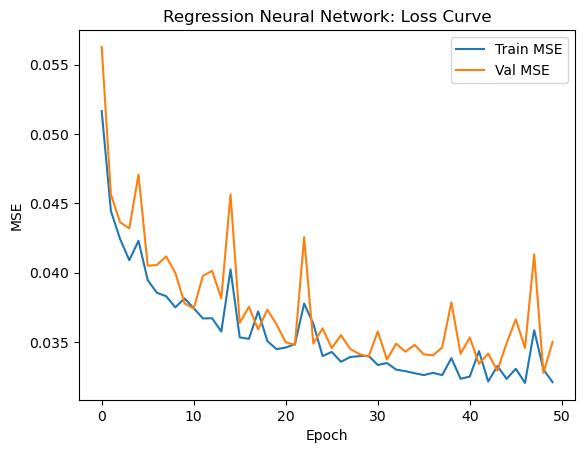

In [21]:
plt.plot(net_reg.train_loss, label="Train MSE")
plt.plot(net_reg.val_loss, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Regression Neural Network: Loss Curve")
plt.legend()
plt.show()


## **Regression Evaluation**



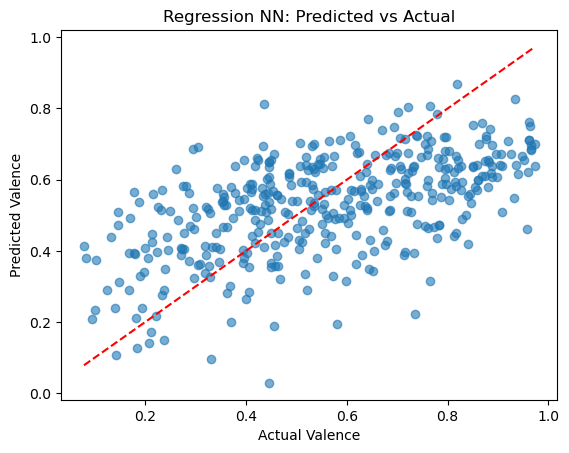

In [24]:
y_pred = [net_reg.feedforward(x.reshape(-1,1))[0,0] for x,y in test_data_reg]
y_true = [y[0] for x,y in test_data_reg]

plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual Valence")
plt.ylabel("Predicted Valence")
plt.title("Regression NN: Predicted vs Actual")
plt.show()


## **Classification Neural Network Overview**

We now construct a binary classifier.

**Classification NN Architecture**

1. Input → Hidden(32) → Hidden(16) → Output(1)
2. Hidden activation: Sigmoid
3. Output activation: Sigmoid
4. Loss: Binary Cross Entropy
5. Optimization: SGD

In [28]:
class ClassifierNN:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(n,1) for n in sizes[1:]]
        self.weights = [np.random.randn(n,m)/np.sqrt(m)
                        for m,n in zip(sizes[:-1],sizes[1:])]

    def sigmoid(self, z): return 1/(1+np.exp(-z))
    def d_sigmoid(self, z): s=self.sigmoid(z); return s*(1-s)

    def feedforward(self, a):
        for b,w in zip(self.biases, self.weights):
            a = self.sigmoid(w@a + b)
        return a

    def backprop(self, x, y):
        nabla_b = [np.zeros_like(b) for b in self.biases]
        nabla_w = [np.zeros_like(w) for w in self.weights]

        activation = x.reshape(-1,1)
        activations=[activation]
        zs=[]

        for b,w in zip(self.biases, self.weights):
            z = w@activation + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        delta = (activations[-1]-y)*self.d_sigmoid(zs[-1])
        nabla_b[-1]=delta
        nabla_w[-1]=delta@activations[-2].T

        for l in range(2, self.num_layers):
            z=zs[-l]
            sp=self.d_sigmoid(z)
            delta=(self.weights[-l+1].T @ delta)*sp
            nabla_b[-l]=delta
            nabla_w[-l]=delta@activations[-l-1].T

        return nabla_b, nabla_w

    def SGD(self, train_data, val_data, epochs, lr):
        self.train_acc=[]
        self.val_acc=[]

        for ep in range(epochs):
            np.random.shuffle(train_data)
            for x,y in train_data:
                nb,nw = self.backprop(x,y)
                self.weights=[w-lr*dw for w,dw in zip(self.weights,nw)]
                self.biases=[b-lr*db for b,db in zip(self.biases,nb)]

            acc_tr = self.evaluate(train_data)
            acc_val = self.evaluate(val_data)
            self.train_acc.append(acc_tr)
            self.val_acc.append(acc_val)

            print(f"Epoch {ep+1}: Train Acc={acc_tr:.4f}, Val Acc={acc_val:.4f}")

    def predict(self, x):
        return int(self.feedforward(x.reshape(-1,1))[0][0] > 0.5)

    def evaluate(self, data):
        preds=[self.predict(x) for x,y in data]
        labels=[int(y[0]) for x,y in data]
        return sum(p==y for p,y in zip(preds,labels))/len(labels)


## **Train Classifier**

In [31]:
train_data_clf = list(zip(X_tr, y_clf_tr))
val_data_clf   = list(zip(X_val, y_clf_val))
test_data_clf  = list(zip(X_te, y_clf_te))

net_clf = ClassifierNN([X_norm.shape[1], 32, 16, 1])
net_clf.SGD(train_data_clf, val_data_clf, epochs=50, lr=0.01)


Epoch 1: Train Acc=0.7183, Val Acc=0.7025
Epoch 2: Train Acc=0.7183, Val Acc=0.7025
Epoch 3: Train Acc=0.7183, Val Acc=0.7025
Epoch 4: Train Acc=0.7183, Val Acc=0.7025
Epoch 5: Train Acc=0.7183, Val Acc=0.7025
Epoch 6: Train Acc=0.7183, Val Acc=0.7025
Epoch 7: Train Acc=0.7183, Val Acc=0.7025
Epoch 8: Train Acc=0.7183, Val Acc=0.7025
Epoch 9: Train Acc=0.7183, Val Acc=0.7025
Epoch 10: Train Acc=0.7183, Val Acc=0.7025
Epoch 11: Train Acc=0.7183, Val Acc=0.7025
Epoch 12: Train Acc=0.7183, Val Acc=0.7025
Epoch 13: Train Acc=0.7183, Val Acc=0.7025
Epoch 14: Train Acc=0.7183, Val Acc=0.7025
Epoch 15: Train Acc=0.7183, Val Acc=0.7025
Epoch 16: Train Acc=0.7183, Val Acc=0.7025
Epoch 17: Train Acc=0.7183, Val Acc=0.7025
Epoch 18: Train Acc=0.7183, Val Acc=0.7025
Epoch 19: Train Acc=0.7183, Val Acc=0.7025
Epoch 20: Train Acc=0.7183, Val Acc=0.7025
Epoch 21: Train Acc=0.7183, Val Acc=0.7025
Epoch 22: Train Acc=0.7183, Val Acc=0.7025
Epoch 23: Train Acc=0.7183, Val Acc=0.7025
Epoch 24: Train Acc=

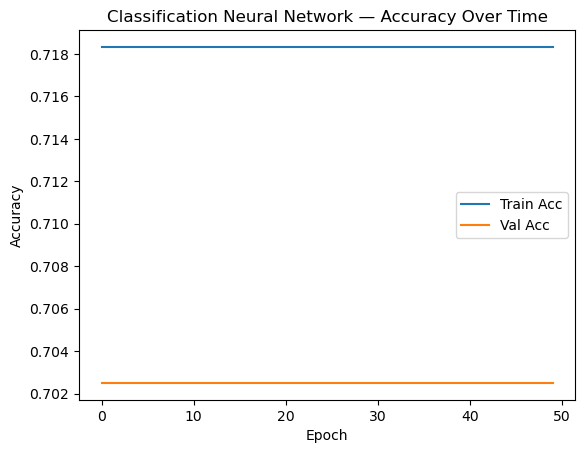

In [37]:
plt.plot(net_clf.train_acc, label="Train Acc")
plt.plot(net_clf.val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classification Neural Network — Accuracy Over Time")
plt.legend()
plt.show()


In [35]:
preds = [net_clf.predict(x) for x,y in test_data_clf]
true  = [int(y[0]) for x,y in test_data_clf]

acc = sum(p==t for p,t in zip(preds,true)) / len(true)
print("Final Test Accuracy:", acc)


Final Test Accuracy: 0.6675


## **Interpretation**

The regression network shows steady improvement over the 50-epoch training window. Train MSE decreases from roughly 0.052 → 0.032, and validation MSE follows a nearly identical trajectory. Both curves remain close together with only minor fluctuations, indicating stable learning without strong overfitting. Small bumps (e.g., around epochs 15 and 48) reflect normal noise from stochastic updates rather than structural issues in the model. By the final epochs, validation MSE stabilizes around 0.033–0.035, suggesting the network consistently captures nonlinear relationships in the audio features when predicting valence.

The classification network behaves differently: both training and validation accuracy plateau at ~0.72 for the entire run. This indicates the model quickly converged to a locally optimal decision boundary and remained there. The stability of the curves suggests no overfitting, but the lack of upward movement implies the network is capacity-limited or the feature set does not strongly separate high- vs low-energy tracks. Additional layers, alternative activations, or feature engineering may be required to achieve further gains.